In [112]:
import pandas as pd
import numpy as np
from dataset_functions import *
seed=10
np.random.seed(seed=10)

# Feature Selection

In [113]:
from sklearn.ensemble import RandomForestClassifier

def fit_feature_selector(X_train:pd.DataFrame,Y_train:pd.DataFrame) -> RandomForestClassifier:
    feature_selector = RandomForestClassifier(max_depth=10,class_weight="balanced",random_state=seed)

    feature_selector.fit(X_train,Y_train)

    return feature_selector

In [114]:
from sklearn.metrics import roc_auc_score, accuracy_score

def feature_selection(
        feature_selector:RandomForestClassifier,
        threshold: float,
        X_train:pd.DataFrame,
        X_test:pd.DataFrame,
        Y_test:pd.DataFrame
    ) -> pd.DataFrame:
    
    Y_pred = feature_selector.predict(X_test)

    acc = accuracy_score(Y_test,Y_pred)
    auc = roc_auc_score(Y_test,Y_pred)

    print("Accouracy:\t",acc)
    print("Roc Auc:\t",auc)

    feature_importance = {
        name: value 
        for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
    }

    feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
    feature_names = list(feature_importance.keys())
    print("Most Important:\n", feature_names[:10])
    print("Least Important:\n", feature_names[-10:])

    n_selected_features = np.sum(np.array(list(feature_importance.values())) > threshold)

    print("Selected Features:\n",feature_names[:n_selected_features])

    X_train_reduced = X_train[feature_names[:n_selected_features]]
    X_test_reduced = X_test[feature_names[:n_selected_features]]
    print("Shape Tranformation:\n",X_train.shape,"->", X_train_reduced.shape)

    return X_train_reduced,X_test_reduced

# Data Loading

In [115]:
print("Retriving Dataset")
df, target = get_dataset()

Retriving Dataset
Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode', 'match_id_hash'] 

Dataframe Shape:  (32153, 242) 

Target shape: (32153, 6)


In [116]:
print("Team Stats-Team Heros:")
df_tt = teamstats_teamheros_transform(df.copy())
print("Player Stats-Team Heros:")
df_pt = playerstats_teamheros_transform(df.copy())
print("Team Mean Position:")
df_mp = team_mean_position_transform(df_tt.copy())
print("Team Weighted Mean Position:")
df_wmp = team_weighted_mean_position_transform(df_tt.copy())

Team Stats-Team Heros:
Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

Dataframe Shape: (32153, 462) 

NaN Count:  0 

Single Hero Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 

In [117]:
win = target["radiant_win"].astype(int)

# Team Stats - Team Heros

In [118]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df_tt,win,test_size=0.2)

In [119]:
feature_selector = fit_feature_selector(X_train,Y_train)

In [120]:
X_train_reduced,X_test_reduced = feature_selection(feature_selector,threshold=0.01,X_train=X_train,X_test=X_test,Y_test=Y_test)

Accouracy:	 0.7107759290934536
Roc Auc:	 0.7085871397509711
Most Important:
 ['r_towers_killed', 'r_deaths', 'd_towers_killed', 'r_kills', 'd_kills', 'd_deaths', 'r5_x', 'r5_y', 'd_gold', 'r4_x']
Least Important:
 ['d_85', 'r_89', 'r_90', 'd_38', 'r_65', 'r_73', 'd_65', 'd_80', 'r_55', 'd_66']
Selected Features:
 ['r_towers_killed', 'r_deaths', 'd_towers_killed', 'r_kills', 'd_kills', 'd_deaths', 'r5_x', 'r5_y', 'd_gold', 'r4_x', 'r1_y', 'd_xp', 'r_gold', 'd1_x', 'r_xp', 'r1_x', 'r2_x', 'd_rune_pickups', 'd4_y', 'r4_y', 'r_rune_pickups', 'r2_y', 'd_assists', 'r_denies', 'r_assists', 'd2_y', 'd4_x', 'd_lh', 'd2_x', 'd_level', 'r3_x', 'r3_y', 'd_denies', 'd5_y', 'd5_x', 'd3_y', 'd_max_health', 'd_health', 'd3_x', 'r_max_health', 'r_level', 'd1_y', 'r_health', 'r_lh', 'd_max_mana', 'r_max_mana']
Shape Tranformation:
 (25722, 294) -> (25722, 46)


In [121]:
Y_pred = feature_selector.fit(X_train_reduced,Y_train).predict(X_test_reduced)
acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)
print("Accouracy ",acc)
print("Auc Score",auc)

Accouracy  0.7148188462136527
Auc Score 0.712442418517282


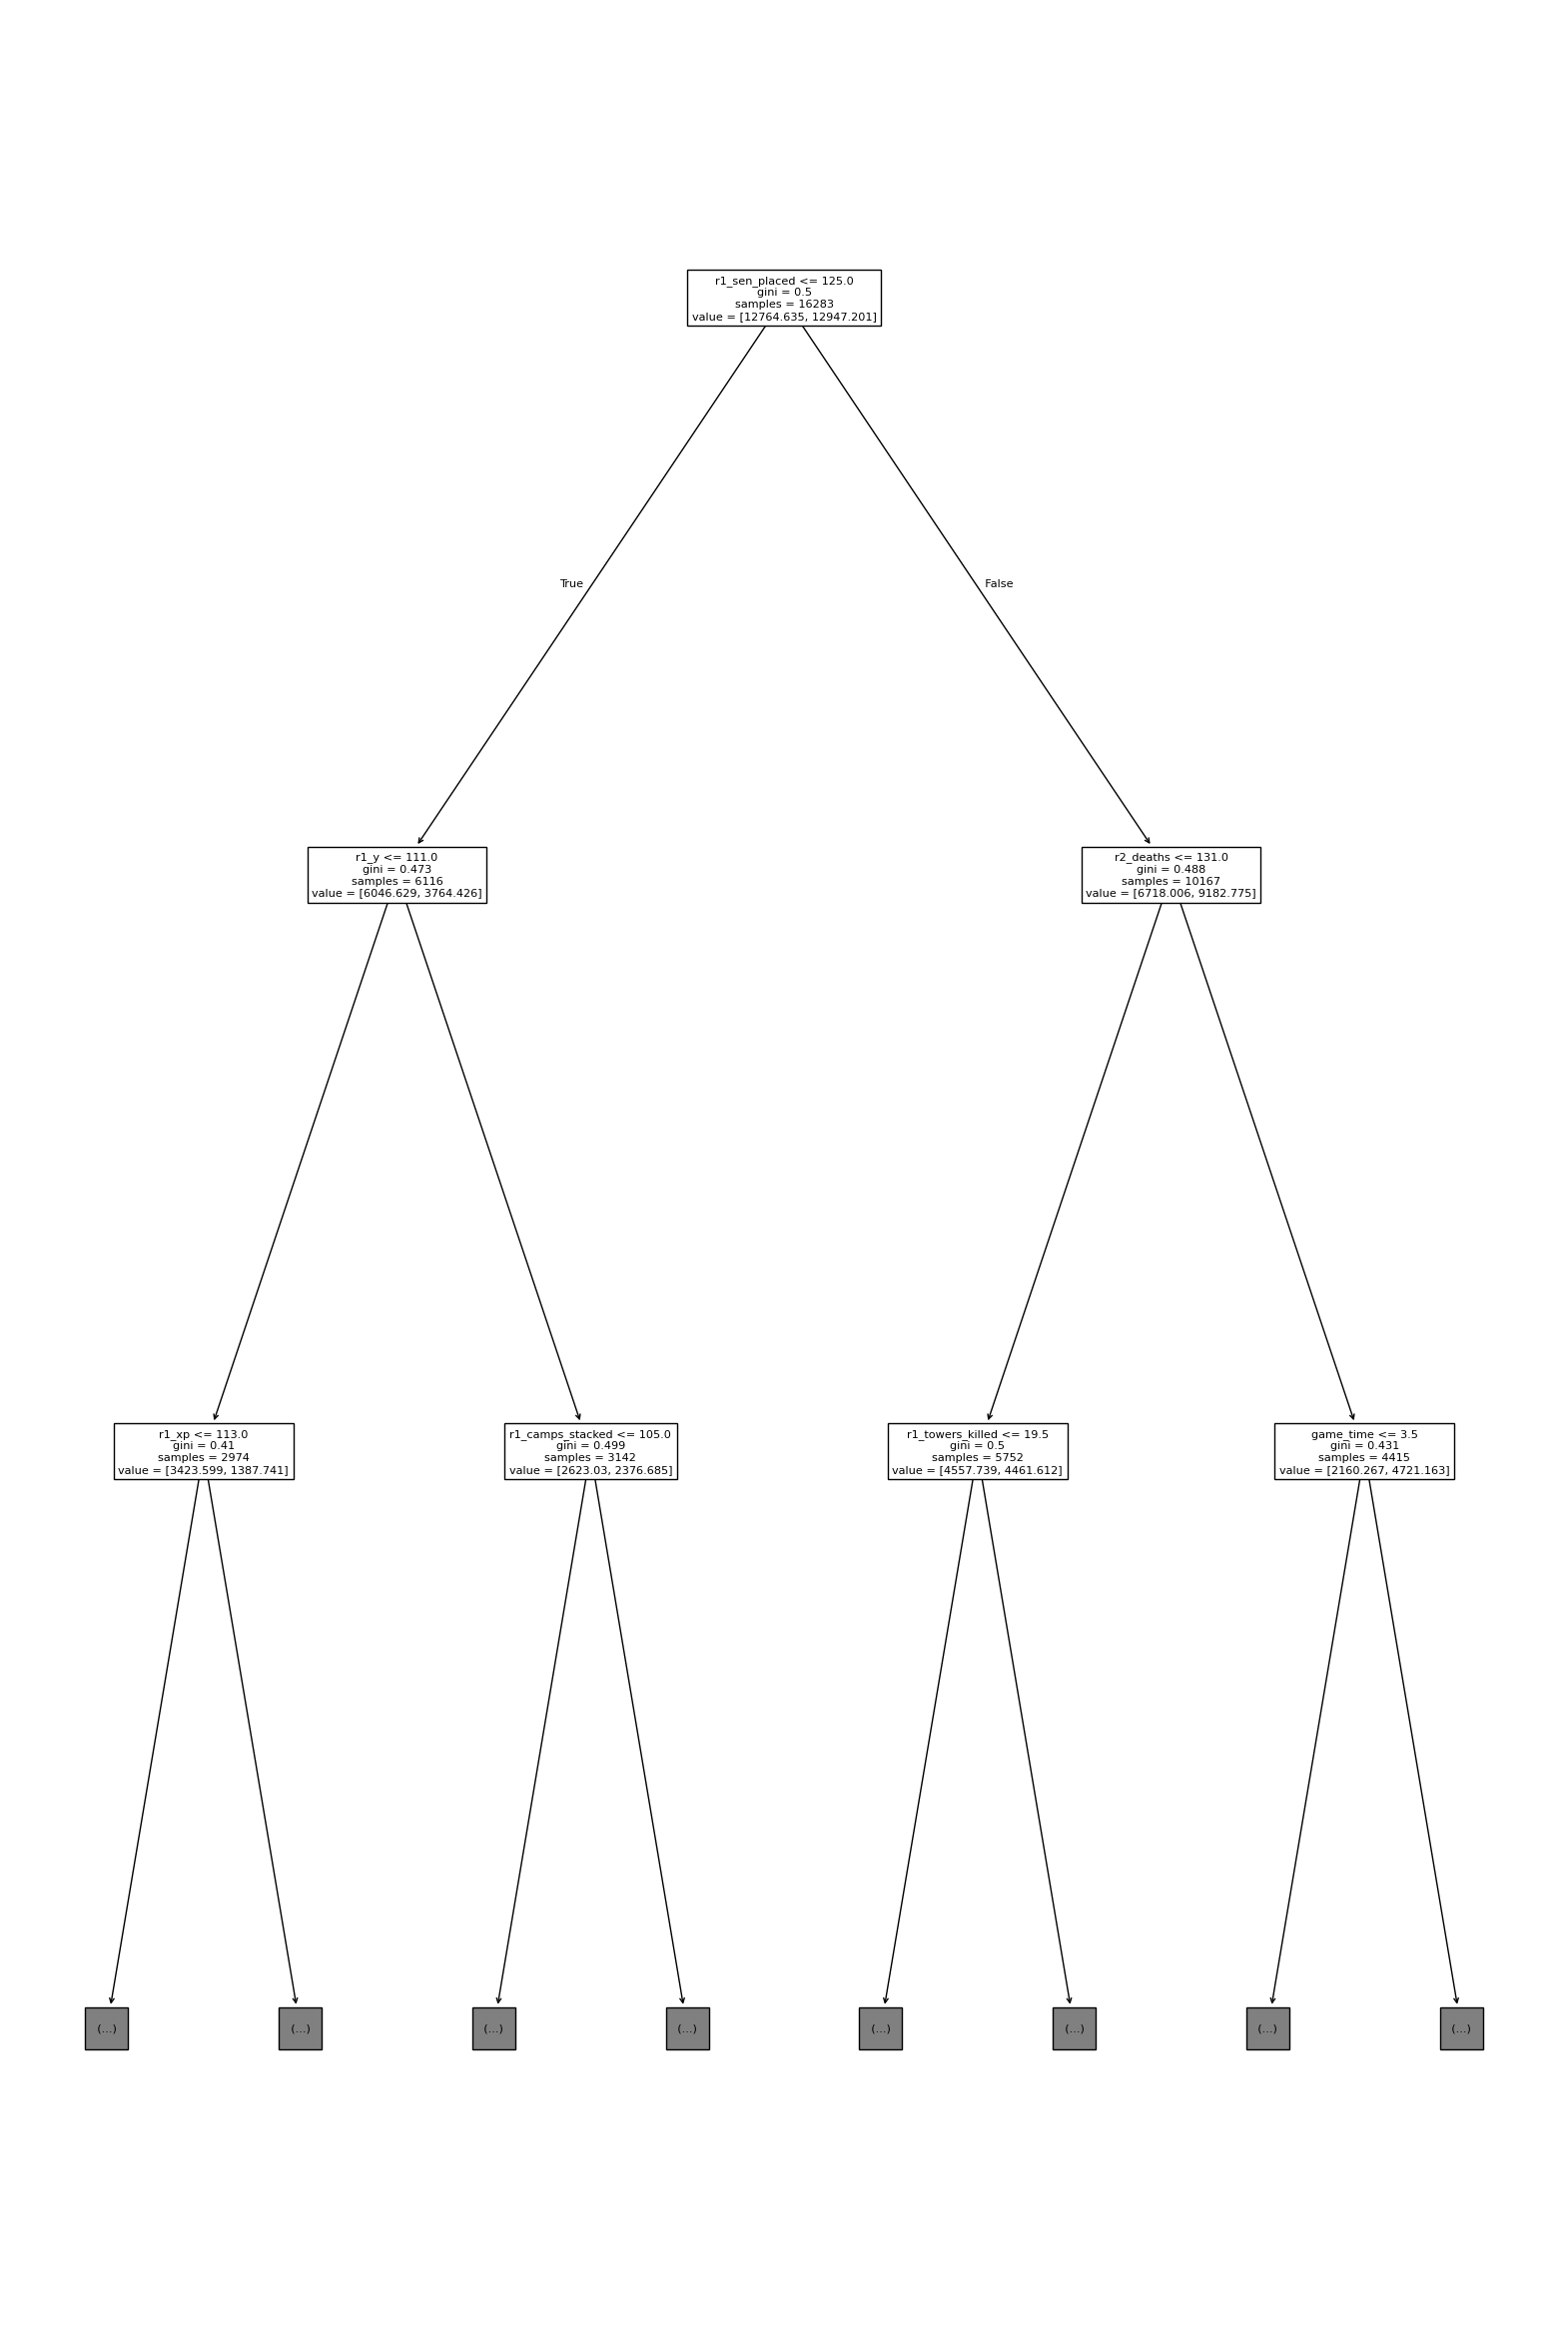

In [122]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = feature_selector.estimators_[1]

plt.figure(figsize=(20,30))
plot_tree(tree,max_depth=2,feature_names=df.columns)
plt.show()

# Player Stats - Team Heros

In [123]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df_pt,win,test_size=0.2)

In [124]:
feature_selector = fit_feature_selector(X_train,Y_train)

In [125]:
X_train_reduced,X_test_reduced = feature_selection(feature_selector,threshold=0.01,X_train=X_train,X_test=X_test,Y_test=Y_test)

Accouracy:	 0.6994246617944332
Roc Auc:	 0.695279829364883
Most Important:
 ['r5_x', 'r1_y', 'r3_x', 'r3_y', 'd3_x', 'r2_y', 'r1_x', 'd5_x', 'r2_x', 'd3_y']
Least Important:
 ['r_113', 'r_111', 'r_63', 'd_65', 'r_61', 'r_60', 'd_82', 'd_52', 'r_55', 'd_66']
Selected Features:
 ['r5_x', 'r1_y', 'r3_x', 'r3_y', 'd3_x', 'r2_y', 'r1_x', 'd5_x', 'r2_x', 'd3_y', 'r4_y', 'd1_y', 'd2_y', 'r5_y', 'd1_x', 'd4_y', 'd2_x', 'd4_x', 'r4_x', 'd5_y']
Shape Tranformation:
 (25722, 462) -> (25722, 20)


In [126]:
Y_pred = feature_selector.fit(X_train_reduced,Y_train).predict(X_test_reduced)
acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)
print("Accouracy ",acc)
print("Auc Score",auc)

Accouracy  0.6599284714663349
Auc Score 0.6562997875794636


# Team Mean Positions

In [127]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df_mp,win,test_size=0.2)

In [128]:
feature_selector = fit_feature_selector(X_train,Y_train)

In [129]:
X_train_reduced,X_test_reduced = feature_selection(feature_selector,threshold=0.01,X_train=X_train,X_test=X_test,Y_test=Y_test)

Accouracy:	 0.7070440055978853
Roc Auc:	 0.7029660040880238
Most Important:
 ['dire_avg_y', 'radiant_avg_y', 'radiant_avg_x', 'dire_avg_x', 'd_towers_killed', 'd_kills', 'r_deaths', 'r_towers_killed', 'd_deaths', 'r_kills']
Least Important:
 ['d_89', 'd_55', 'r_60', 'd_65', 'r_55', 'r_37', 'r_80', 'd_111', 'r_66', 'd_80']
Selected Features:
 ['dire_avg_y', 'radiant_avg_y', 'radiant_avg_x', 'dire_avg_x', 'd_towers_killed', 'd_kills', 'r_deaths', 'r_towers_killed', 'd_deaths', 'r_kills', 'r3_x', 'd3_y', 'd_gold', 'r_denies', 'd_assists', 'r5_x', 'd_xp', 'r4_y', 'r_rune_pickups', 'd_rune_pickups', 'r2_y', 'r_gold', 'd_denies', 'r1_y', 'r_assists', 'r1_x', 'd1_y', 'd_health', 'd_max_health', 'd2_y', 'r_xp', 'd4_x', 'r3_y', 'r_health', 'r_lh', 'r4_x', 'r5_y', 'd1_x', 'd2_x', 'd5_x', 'r_max_health', 'd4_y', 'd5_y', 'd_lh', 'd_max_mana', 'd_level', 'r_level']
Shape Tranformation:
 (25722, 298) -> (25722, 47)


In [130]:
Y_pred = feature_selector.fit(X_train_reduced,Y_train).predict(X_test_reduced)
acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)
print("Accouracy ",acc)
print("Auc Score",auc)

Accouracy  0.7089099673456695
Auc Score 0.7052576203347592


# Team Weighted Mean Positions

In [131]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df_wmp,win,test_size=0.2)

In [132]:
feature_selector = fit_feature_selector(X_train,Y_train)

In [133]:
X_train_reduced,X_test_reduced = feature_selection(feature_selector,threshold=0.01,X_train=X_train,X_test=X_test,Y_test=Y_test)

Accouracy:	 0.708754470533354
Roc Auc:	 0.7066076286096301
Most Important:
 ['dire_Weighted_avg_y', 'radiant_Weighted_avg_y', 'radiant_Weighted_avg_x', 'dire_Weighted_avg_x', 'd_towers_killed', 'r_kills', 'd_kills', 'r_deaths', 'r_towers_killed', 'd_deaths']
Least Important:
 ['r_82', 'r_85', 'r_80', 'd_37', 'r_66', 'r_55', 'd_66', 'd_111', 'd_80', 'd_55']
Selected Features:
 ['dire_Weighted_avg_y', 'radiant_Weighted_avg_y', 'radiant_Weighted_avg_x', 'dire_Weighted_avg_x', 'd_towers_killed', 'r_kills', 'd_kills', 'r_deaths', 'r_towers_killed', 'd_deaths', 'd_gold', 'r3_x', 'd3_y', 'r5_x', 'r_gold', 'd_xp', 'd_rune_pickups', 'r_assists', 'r5_y', 'r2_y', 'd_assists', 'r_rune_pickups', 'd_denies', 'd5_x', 'd1_x', 'd_health', 'd2_y', 'r_denies', 'd4_x', 'r4_x', 'r1_y', 'd_max_health', 'r_lh', 'r3_y', 'r1_x', 'r4_y', 'd1_y', 'd4_y', 'd_lh', 'r_xp', 'd2_x', 'd_level', 'r2_x', 'r_level', 'r_health', 'd5_y', 'r_max_health', 'd3_x']
Shape Tranformation:
 (25722, 298) -> (25722, 48)


In [134]:
Y_pred = feature_selector.fit(X_train_reduced,Y_train).predict(X_test_reduced)
acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)
print("Accouracy ",acc)
print("Auc Score",auc)

Accouracy  0.710931425905769
Auc Score 0.7090868550630809


# Sequential Feature Selection

In [100]:
from sklearn.feature_selection import SequentialFeatureSelector

df_tt_dropped_heros = drop_heros_labels(df_tt.copy())

sf = SequentialFeatureSelector(estimator=feature_selector,tol=0.01,direction='forward')

Hero Id Labels: [] 

Dropped Dataframe Shape: (32153, 64)


In [101]:
sf.fit(df_tt_dropped_heros,win)

SequentialFeatureSelector(estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=10),
                          tol=0.01)

In [103]:
sf.get_feature_names_out()
sf.scoring

In [108]:
model = RandomForestClassifier(**feature_selector.get_params())
X_train,X_test,Y_train,Y_test = train_test_split(df_tt_dropped_heros,win,test_size=0.2)

In [109]:
model.fit(sf.transform(X_train),Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [111]:
Y_pred  = model.predict(sf.transform(X_test))
print(accuracy_score(Y_pred,Y_test))
print(roc_auc_score(Y_pred,Y_test))

0.6927382988648733
0.69179933403221
